# Logistic regression

In [1]:
import numpy as np
import pandas as pd
# Safe setting for Pandas.
pd.set_option('mode.copy_on_write', True)
import matplotlib.pyplot as plt
from jupyprint import arraytex, jupyprint
# Optimization function
from scipy.optimize import minimize
# For interactive widgets.
from ipywidgets import interact

In this page we will look at another regression technique: logistic regression.
We use logistic regression when we want to use a *binary categorical*
variable as our *outcome* variable This contrasts with using a binary categorical 
variable *as* a predictor variable, as we've seen on the other [textbook](https://lisds.github.io/dsip/linear_regression_categorical_predictors.html) [pages](https://lisds.github.io/dsip/multiple_predictors_statistical_adjustment.html). 

As we know, a binary categorical variable is one where an observation can fall
into one of only two categories. We give each observation a label corresponding to their
category.  Some examples are:

* Did a patient die or did they survive through 6 months of treatment?  The
  patient can only be in only one of the categories.  In some column of our
  data table, patients that died might have the label "died", and those who
  have survived have the label "survived".
* Did a person experience more than one episode of psychosis in the last 5
  years ("yes" or "no")?
* Did a person with a conviction for one offense offend again ("yes" or "no")?

For this tutorial, we return to the [chronic kidney disease
dataset](../data/chronic_kidney_disease), which you have seen previously.

Each oberservational unit in this dataset is one patient.

For each patient, the doctors recorded whether or not the patient had chronic
kidney disease. This is a *binary categorical variable*; you can see the
values in the "Class" column. A value of 1 means the patient *did* have CKD; a
value of 0 means they *did not*.  Remember that these numbers are not true numbers:
they are labels that denote category membership, but by using numbers as labels 
we can "trick" a regression model into including the variable.

Many of the rest of the columns in the dataframe are measurements from blood tests and urine tests.

In [2]:
# read in the data
df = pd.read_csv('data/ckd_clean.csv')
df.head(20)

,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Blood Glucose Random,...,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
0,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,1
1,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,1
2,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,380.0,...,32.0,4500.0,3.8,yes,yes,no,poor,yes,no,1
3,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,157.0,...,16.0,11000.0,2.6,yes,yes,yes,poor,yes,no,1
4,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,173.0,...,24.0,9200.0,3.2,yes,yes,yes,poor,yes,yes,1
5,48.0,80.0,1.025,4.0,0.0,normal,abnormal,notpresent,notpresent,95.0,...,32.0,6900.0,3.4,yes,no,no,good,no,yes,1
6,69.0,70.0,1.010,3.0,4.0,normal,abnormal,notpresent,notpresent,264.0,...,37.0,9600.0,4.1,yes,yes,yes,good,yes,no,1
7,73.0,70.0,1.005,0.0,0.0,normal,normal,notpresent,notpresent,70.0,...,29.0,18900.0,3.5,yes,yes,no,good,yes,no,1
8,73.0,80.0,1.020,2.0,0.0,abnormal,abnormal,notpresent,notpresent,253.0,...,33.0,7200.0,4.3,yes,yes,yes,good,no,no,1
9,46.0,60.0,1.010,1.0,0.0,normal,normal,notpresent,notpresent,163.0,...,28.0,14600.0,3.2,yes,yes,no,good,no,no,1


There are actually a large number of binary categorical variables in this
dataset.   For example, the "Hypertension" column has labels for the two
categories "yes" (the patient had persistently high blood pressure) or "no".

The categorical variable we are interested in here is "Appetite".  This has
the label "good" for patients with good appetite, and "poor" for those with
poor appetite.  Poor appetite is a [symptom of chronic kidney
disease](https://www.sciencedirect.com/science/article/abs/pii/S0270929508001666).  In our case, we wonder whether the extent of kidney damage does a convincing job in predicting whether the patient has a "good" appetite.

The CKD dataset has a column "Hemoglobin" that has the
concentration of hemoglobin from a blood sample.  Hemoglobin is the molecule
that carries oxygen in the blood; it is the molecule that makes the red blood
cells red.  Damaged kidneys produce lower concentrations of the hormone that
stimulates red blood cell production,
[erythropoietin](https://en.wikipedia.org/wiki/Erythropoietin), so CKD
patients often have fewer red blood cells, and lower concentrations of
Hemoglobin.  We will take lower "Hemoglobin" as a index of kidney damage.
Therefore, we predict that patients with lower "Hemoglobin" values are more
likely to have `poor` "Appetite" values, and, conversely, patients with higher
"Hemoglobin" values are more likely to have `good` "Appetite" values.

First we make a new data frame that just has the two columns we are interested
in:

In [3]:
# isolate only the variables of interest
hgb_app = df.loc[:, ['Hemoglobin', 'Appetite']]

# rename the columns for easier typing
hgb_app = hgb_app.rename(columns = {'Hemoglobin': 'hemoglobin',
                                    'Appetite' : 'appetite'})
hgb_app.head(20)

,hemoglobin,appetite
0,11.2,poor
1,9.5,poor
2,10.8,poor
3,5.6,poor
4,7.7,poor
5,9.8,good
6,12.5,good
7,10.0,good
8,10.5,good
9,9.8,good


## Dummy Variables

The model we want to fit is here is:

`appetite` ~ `hemoglobin`

Which we read as "we want to model `appetite` as a function of `hemoglobin`".

We will soon find ourselves wanting to do calculations on the values in the
`appetite` column, and we cannot easily do that with the current string values
of "good" and "poor", for the reasons we've seen previously, on the categorical 
predictors [page](https://lisds.github.io/dsip/linear_regression_categorical_predictors.html).

Just as when we use a categorical variable as a predictor,
our next step is to recode the string values to
numbers, ready for our calculations.  We use 1 to represent "good" and 0 to
represent "poor".  This kind of recoding, where we replace category labels
with 1 and 0 values, is often called *dummy coding*. The notation for the current
dummy-coding scheme is:

`appetite_dummy` $ = \begin{cases} 1, & \text{if $i$ is `good`} \\ 0, & \text{if $i$ is `poor`} \end{cases} $

In [4]:
# 'replace' replaces the values in the first argument with the corresponding
# values in the second argument.
hgb_app['appetite_dummy'] = hgb_app['appetite'].replace(['poor', 'good'],
                                                        [0, 1])
hgb_app.head(20)

,hemoglobin,appetite,appetite_dummy
0,11.2,poor,0
1,9.5,poor,0
2,10.8,poor,0
3,5.6,poor,0
4,7.7,poor,0
5,9.8,good,1
6,12.5,good,1
7,10.0,good,1
8,10.5,good,1
9,9.8,good,1


*Note*: When you are doing this, be sure to keep track of which label you have
coded as 1. Normally this would be the more interesting outcome.  In this
case, "good" has the code 1. Keep track of the label corresponding to 1, as it
will affect the interpretation of the regression coefficients.

Now we have the dummy (1 or 0) variable, let us use a scatter plot to look at
the relationship between hemoglobin concentration and whether a patient has a
good appetite.

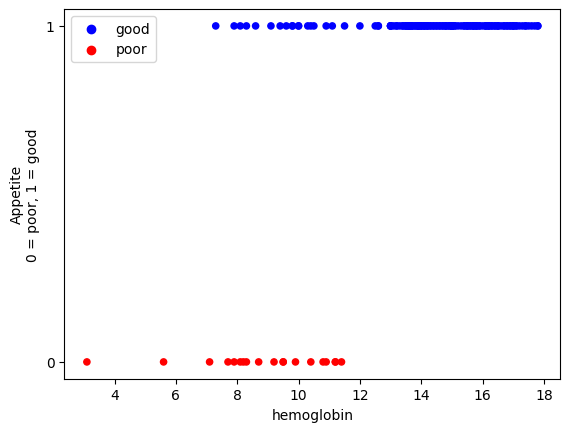

In [5]:
# We will use this plotting code several times, so put into a function for
# later use.
def plot_hgb_app():
    # Build plot, add custom labels.
    colors = hgb_app['appetite'].replace(['poor', 'good'], ['red', 'blue'])
    hgb_app.plot.scatter('hemoglobin', 'appetite_dummy', c=colors)
    plt.ylabel('Appetite\n0 = poor, 1 = good')
    plt.yticks([0,1]);  # Just label 0 and 1 on the y axis.
    # Put a custom legend on the plot.  This code is a little obscure.
    plt.scatter([], [], c='blue', label='good')
    plt.scatter([], [], c='red', label='poor')

# Do the plot
plot_hgb_app()
# Show the legend
plt.legend();

From the plot, it does look as if the patients with lower hemoglobin are more
likely to have poor appetite (`appetite_dummy` values of 0), whereas patients
with higher hemoglobin tend to have good appetite (`appetite_dummy` values of
1).

Now we start to get more formal, and develop a model with which we predict the
`appetite_dummy` values from the  `Hemoglobin` values.


## How about linear regression?

Remember that, in linear regression, we predict scores on the *outcome*
variable (or vector) using a straight-line relationship of the *predictor*
variable (or vector).

Here are the predictor and outcome variables in our case - we'll store these
as separate variables to save some typing:

In [6]:
# The x (predictor) and y (outcome) variables.
hemoglobin = hgb_app['hemoglobin']
appetite_d = hgb_app['appetite_dummy']

Why not use linear regression for the present data? After all, our *outcome variable* (`appetite_d`) and our *predictor variable* (`hemoglobin`) here are both sequences of numbers, with one value for each observational unit (row) in the dataset. The linear model here is shown below, using the first 20 values of each vector (to stop the printout being unwieldy)!:

In [7]:
# do not worry about this code, it just generates the notation below
jupyprint("Here is the our model ($ \\vec{y} = b \\vec{x} + \\text{c} + \\vec{\\varepsilon} $), showing the first 10 actual values within the `hemoglobin` and `appetite_d` vectors:")
jupyprint(f"${arraytex(np.atleast_2d(appetite_d[:20]).T)} = b * {arraytex(np.atleast_2d(hemoglobin[:20]).T)} + c +" +" \\vec{\\varepsilon}$")

Here is the our model ($ \vec{y} = b \vec{x} + \text{c} + \vec{\varepsilon} $), showing the first 10 actual values within the `hemoglobin` and `appetite_d` vectors:

$\begin{bmatrix}{} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1 \\ 1 \\ 1 \\ 1 \\ 1 \\ 1 \\ 1 \\ 0 \\ 1 \\ 1 \\ 1 \\ 0 \\ 0 \\ 1 \\ 0 \\ \end{bmatrix} = b * \begin{bmatrix}{} 11.2 \\ 9.5 \\ 10.8 \\ 5.6 \\ 7.7 \\ 9.8 \\ 12.5 \\ 10.0 \\ 10.5 \\ 9.8 \\ 9.1 \\ 10.3 \\ 7.1 \\ 13.0 \\ 16.1 \\ 10.4 \\ 9.2 \\ 11.4 \\ 8.1 \\ 8.2 \\ \end{bmatrix} + c + \vec{\varepsilon}$

Let's compare the values in the vectors above to the first 20 values of each variable in the `hgb_app` dataframe, just to
assure ourselves they are the same:

In [8]:
# for comparison with the vectors above
hgb_app[['appetite_dummy', 'hemoglobin']].iloc[:20]

,appetite_dummy,hemoglobin
0,0,11.2
1,0,9.5
2,0,10.8
3,0,5.6
4,0,7.7
5,1,9.8
6,1,12.5
7,1,10.0
8,1,10.5
9,1,9.8


This looks like something our linear regression machinery will be able to work with.

In contrast to the vector printout above, we actually have many more than 20 observational units:

In [9]:
jupyprint(f'Rows in CKD data: {len(hgb_app)}')

Rows in CKD data: 158

We are familiar now with performing linear regression to
find the value of the slope and intercept of the line which gives the smallest
sum of the squared prediction errors.

Recall that, in linear regression:

$ \text{(predicted scores)} = b * \text{(predictor variable)} + c $

Or, in mathematical notation:

$\Large \vec{\hat{y}} = b \vec{x} + \text{c}$

As we know, there will be the same number of scores on the
predictor variable (`hemoglobin`), and the same number of predictions ($\hat{y}$).
By contrast, the slope and intercept are single values, defining
the line.

We used `minimize` to find the values of the slope and intercept which give the
"best" predictions.  So far, we have almost invariably defined the *best*
values for slope and intercept as the values that give the smallest sum of the
squared prediction errors.

$\text{(prediction errors)} = \text{(actual scores) - (predicted scores)}$

Or, in mathematical notation:

$$
\vec{\varepsilon}= \begin{bmatrix}
           \varepsilon_1 \\
           \varepsilon_2 \\
           \vdots \\
           \varepsilon_n
         \end{bmatrix} = \begin{bmatrix}
           y_1 - \hat{y}_1 \\
           y_2 - \hat{y}_2 \\
           \vdots \\
           y_n - \hat{y}_n
         \end{bmatrix}         = 
         \begin{bmatrix}
           y_1 - (b x_1 + c)\\
           y_2 - (b x_2 + c) \\
           \vdots \\
           y_n - (b x_n + c)
         \end{bmatrix}         
$$

What would happen if we tried to use linear regression to predict the
appetite scores, based on hemoglobin concentrations?

Let us start by grabbing the our familiar `ss_any_line` function from the
[Using minimize page](../mean-slopes/using_minimize.Rmd).

In [10]:
def ss_any_line(intercept_and_slope, x_values, y_values):
    
    # Intercept_and_slope is a list containing two elements, an intercept and a slope.
    intercept, slope =intercept_and_slope
    
    # Values predicted from these x_values, using this intercept and slope.
    predicted = intercept + x_values * slope
    
    # Difference of prediction from the actual y values.
    error = y_values - predicted
    
    # Sum of squared error.
    return np.mean(error ** 2)

As we know, the sum of the squared prediction error, in linear regression, is our *cost*
function. When we have a good pair of (intercept, slope) in `intercept_and_slope`, our function
is *cheap* - i.e. the returned value is small.  When we have a bad pair in
`intercept_and_slope`, our function is *expensive* - the returned value is large.

If the value from `ss_any_line` is large, it means the line we are fitting
does not fit the data well. The purpose of linear regression is to find the
line which leads to the smallest cost.  In our case, the cost is the sum of the
squared prediction errors.

Let's use linear regression on the current example.  From looking at our plot
above, we start with a guess of -1 for the intercept, and 0.1 for the slope.

In [11]:
# Use minimize to find the least sum of squares solution.
min_lin_reg = minimize(ss_any_line, [-1, 0.1], args=(hemoglobin, appetite_d))
# Show the results that came back from minimize.
min_lin_reg

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.06528803495205858
        x: [-7.904e-02  7.005e-02]
      nit: 3
      jac: [ 1.863e-09  1.863e-09]
 hess_inv: [[ 1.185e+01 -8.291e-01]
            [-8.291e-01  6.057e-02]]
     nfev: 18
     njev: 6

OK, so that looks hopeful. Using linear regression with `minimize` we found that the sum of squared prediction errors was smallest for a line with:

In [12]:
# Unpack the slope and intercept estimates from the results object.
lin_reg_intercept, lin_reg_slope = min_lin_reg.x
# Show them.
jupyprint(f'Best linear regression intercept <b> {lin_reg_intercept.round(2)}</b>')
jupyprint(f'Best linear regression slope <b> {lin_reg_slope.round(2)} </b>')

Best linear regression intercept <b> -0.08</b>

Best linear regression slope <b> 0.07 </b>

Let's calculate the predicted scores, from the now familiar formula:

$\vec{\hat{y}} = b \vec{x} + \text{c}$

Which, in python terms, in the current case, is:

```
predicted_scores= lin_reg_slope * hemoglobin + lin_reg_intercept
```

In [13]:
# calculate the predicted values
predicted_lin_reg = lin_reg_slope * hemoglobin + lin_reg_intercept 
predicted_lin_reg

0      0.705510
1      0.586427
2      0.677491
3      0.313234
4      0.460338
         ...   
153    1.020732
154    1.076771
155    1.027737
156    0.915658
157    1.027737
Name: hemoglobin, Length: 158, dtype: float64

Let's plot our predictions, alongside the actual data.  We plot the predictions
from linear regression in orange.

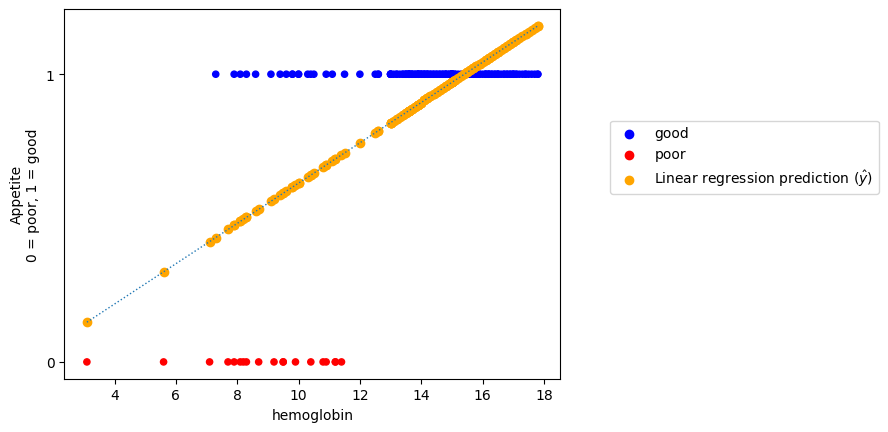

In [14]:
# Do the base plot of the hemoglobin and appetite_d.
plot_hgb_app()

# A new plot on top of the old.
plt.scatter(hemoglobin, predicted_lin_reg,
            label='Linear regression prediction $(\hat{y}$)',
            color='orange')
# Another plot, to show the underlying line
fine_x = np.linspace(np.min(hemoglobin), np.max(hemoglobin), 1000)
fine_y = lin_reg_intercept + lin_reg_slope * fine_x
plt.plot(fine_x, fine_y, linewidth=1, linestyle=':')
# Show the legend.
plt.legend(loc=(1.1, 0.5));

<i> <b> Question: </b> can anyone see any issues with our predictions here? </i>

The linear regression line looks plausible, as far as it goes, but it has
several unhappy features for our task of predicting the `appetite_d` 0 or 1
values.

One thing to like about the line is that the predictions are right to suggest
that the value of `appetite_d` is more likely to be 1 (meaning "good") at
higher values of `hemoglobin`.  Also, the prediction line slopes upward as
`hemoglobin` gets higher, indicating that the probability of good appetite gets
higher as the hemoglobin concentration rises, across patients.

However, when the `hemoglobin` gets higher than about 15.5, linear regression
starts to predict a value for `appetite_d` that is greater than 1 - which, of
course, cannot occur in the `appetite_d` values, which are restricted to 0 or
1.

In fact, if we make predictions from this model for sufficiently low hemoglobin
values, we find that our predictions for `appettite_d` also fall *below* 0, which
again, is not a possible value of `appetite_d`:

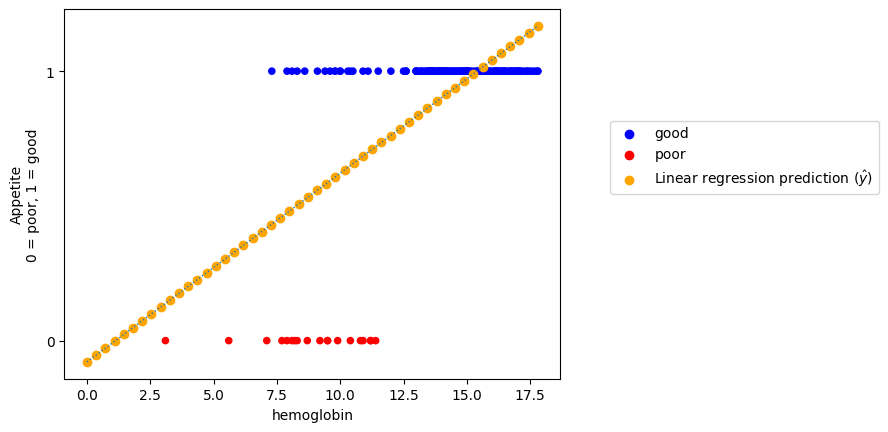

In [15]:
# Do the base plot of the hemoglobin and appetite_d.
plot_hgb_app()

# A new plot on top of the old.
plt.scatter(np.linspace(0, hemoglobin.max()), 
            lin_reg_intercept + lin_reg_slope* np.linspace(0, hemoglobin.max()),
            label='Linear regression prediction $(\hat{y}$)',
            color='orange')
# Another plot, to show the underlying line
fine_x = np.linspace(0, np.max(hemoglobin), 1000)
fine_y = lin_reg_intercept + lin_reg_slope * fine_x
plt.plot(fine_x, fine_y, linewidth=1, linestyle=':')
# Show the legend.
plt.legend(loc=(1.1, 0.5));

The problem here is that linear regression can produce predicted values ($\hat{y}$) ranging from negative infinity to positive infinity. One way of saying this is that the predictions from linear regression are unconstrained or unbounded.

However, the outcome variable we are trying to predict (`appetite_d`) *is* constrained/bounded: it can only take values of either 0 or 1.

The plot below shows this problem, by showing the linear regression line for very large and very small values of `hemoglobin`, based on the model parameters:

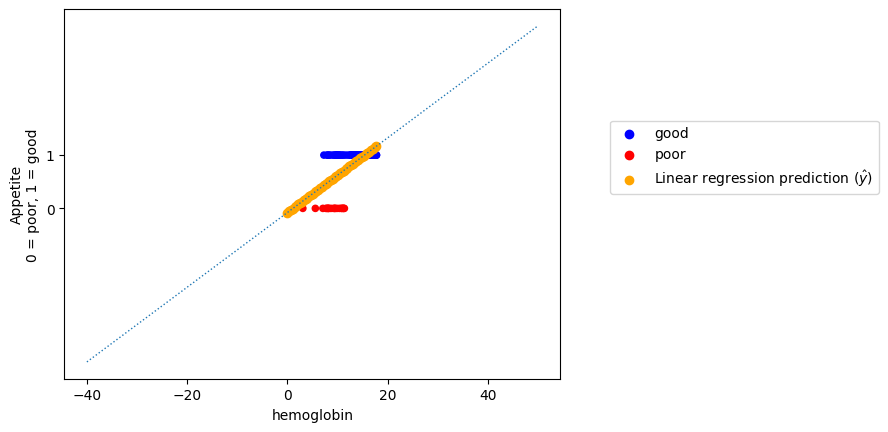

In [16]:
# Do the base plot of the hemoglobin and appetite_d.
plot_hgb_app()

# A new plot on top of the old.
plt.scatter(np.linspace(0, hemoglobin.max()), 
            lin_reg_intercept + lin_reg_slope* np.linspace(0, hemoglobin.max()),
            label='Linear regression prediction $(\hat{y}$)',
            color='orange')
# Another plot, to show the underlying line
fine_x_big = np.linspace(-40, 50, 1000)
fine_y_big = lin_reg_intercept + lin_reg_slope * fine_x_big
plt.plot(fine_x_big, fine_y_big, linewidth=1, linestyle=':')
# Show the legend.
plt.legend(loc=(1.1, 0.5));

These reflections might make as wonder whether we should be using something other
than a simple, unconstrained straight line for our predictions.

## Another prediction line

Here's another prediction line we might use for `appetite_d`, with the
predicted values. For the moment, let's not worry about how we came by this line, we will come
onto that soon. (If it wasn't obvious, this is the sort of prediction line we get from 
logistic regression)! 

We will show to the mechanics of how we get such a prediction line - 
but for now, we will only say it involves a different cost function
to the one we use in linear regression. 

For now, let's appreciate why the new line might work better than the linear regression line, for the
current data. 

The new prediction line is in gold.

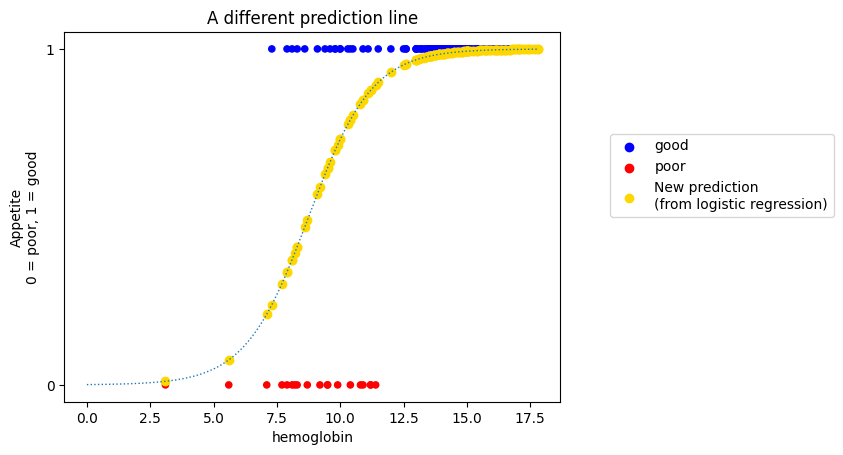

In [17]:
# This is the machinery for making the sigmoid line of the plots below.  We
# will come on that machinery soon.  For now please ignore this code, and
# concentrate on the plots below.
def inverse_logit(y):
    """ Reverse logit transformation
    """
    odds = np.exp(y)  # Reverse the log operation.
    return odds / (odds + 1)  # Reverse odds operation.


def params_to_predicted_probabilities(intercept, slope, x):
    """ Calculate predicted probability of of `dummy_variable == 1` for each observation.
    """
    # Predicted log odds of being in class 1.
    predicted_log_odds = intercept + slope * x
    return inverse_logit(predicted_log_odds)


# Some plausible values for intercept and slope.
nice_intercept, nice_slope = -7, 0.8
predictions_new = params_to_predicted_probabilities(nice_intercept, nice_slope, hemoglobin)

# Do the base plot of the hemoglobin and appetite_d.
plot_hgb_app()

# A new plot on top of the old.
plt.scatter(hemoglobin, predictions_new,
            label='New prediction \n(from logistic regression)',
            color='gold')
# Another plot, to show the underlying line
fine_y_sigmoid = params_to_predicted_probabilities(nice_intercept, nice_slope, fine_x)
plt.plot(fine_x, fine_y_sigmoid, linewidth=1, linestyle=':')
# Show the legend.
plt.legend(loc=(1.1, 0.5))
plt.title('A different prediction line');

The new not-straight line - from now on let's call it a curve - seems to have much to recommend it.  This shape of
curve is called "sigmoid", from the name of the Greek letter "s".  

One nice feature of the sigmoid curve is that the sigmoid
prediction here never goes above 1 or below 0, so its values are always in the
range of the `appetite_d` data it is trying to predict. 

The sigmoid curve climbs steeply to a prediction of 1, and plateaus there, as we get to the
threshold of hemoglobin around 12.5, at which every patient does seem to have
"good" appetite (`appetite_d` of 1). This is a nice feature, as the predictions
at higher values of `hemoglobin` fit the data better than the linear regression line did.

We can think of the values from the sigmoid curve as being *predicted
probabilities* an observational unit falling in whichever category we
have dummy coded as 1.

So in the present case, the curve shows us the predicted probability of having
a good appetite, for each observational unit (patient), given that patient's
`hemoglobin` score.

For example, at a `hemoglobin` value of 10, the curve gives a
predicted y (`appetite_d`) value of about 0.73.  We can interpret this
prediction as saying that, with a hemoglobin value of 10, there is a
*probability* of about 0.73 that the corresponding patient will have a "good"
appetite (`appetite_d` value of 1).

Red dashed lines have been added to the plot, to show this prediction:

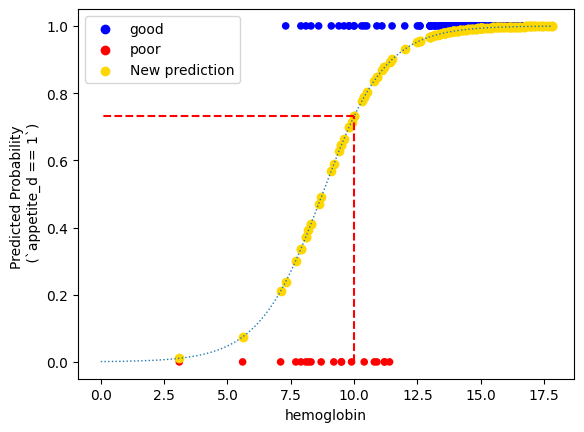

In [18]:
# Do the base plot of the hemoglobin and appetite_d.
plot_hgb_app()
plt.yticks(np.linspace(0, 1, 6).round(2))
plt.ylabel('Predicted Probability \n (`appetite_d == 1`)')

# A new plot on top of the old.
plt.scatter(hemoglobin, predictions_new,
            label='New prediction',
            color='gold')
# Another plot, to show the underlying line
fine_y_sigmoid = params_to_predicted_probabilities(nice_intercept, nice_slope, fine_x)
plt.plot(fine_x, fine_y_sigmoid, linewidth=1, linestyle=':')
plt.plot([10, 10], 
         [0, params_to_predicted_probabilities(nice_intercept, nice_slope, 10)], 
         color='red', linestyle='--')
plt.plot([10, 0], 
         [params_to_predicted_probabilities(nice_intercept, nice_slope, 10),
          params_to_predicted_probabilities(nice_intercept, nice_slope, 10)],
         color='red', linestyle='--')
# Show the legend.
plt.legend();

The sigmoid curve, which we get via logistic regression, is exploiting the fact that probabilities range between 0 and 1,
and that our outcome variable is also constrained to be either 0 or 1. This
means we can meaningfully show the prediction line (showing the predicted 
probabilities) and the outcome variable scores (0 or 1) on the same plot. (We will come 
on to the mechanics of the fitting process later in the page).

Because of these appealing features, let's say we do want to use this kind of
sigmoid line to predict `appetite_d`.  So far, we have only asked `minimize`
to predict directly from a straight line - for example, in the `ss_any_line` function.

How can we get `minimize` to predict from a family of sigmoid curves, as here? 

We'd like to keep the machinery here as familiar as possible. So, ideally we'd like
to send a slope and intercept pair to `minimize`. How might we do that for a sigmoid curve,
given that a slope and intercept denote a straight line, rather than a curve?

We would need a conversion to transform a sigmoid curve like the one here, with y values from 0 to 1,
into a straight line, where the y values can vary from large negative number to large
positive number. Doing such a conversion, so we have a slope and
intercept that `minimize` can work with easily.

Fortunately, our mathematician friends can assure us that we can in fact go from our sigmoid curve (ranging
between 0 and 1) to a straight line with unconstrained y values, in two fairly simple steps. The
next sections will cover those steps.  The two steps are:

* Convert the 0 or 1 *probability* predictions to
  predictions of the *odds*.  The odds can vary from 0 to very
  large positive number.
* Apply the *logarithm* function to convert the 0-to-very-large-positive
  odds predictions to *log* odds predictions, which can vary from
  very large negative number to very large positive number.
  
(Do not worry if these steps don't make sense yet - we'll go over them in more detail below).

These two transformations together are called the *log-odds* or
[logit](https://en.wikipedia.org/wiki/Logit) transformation.  *Logistical
regression* is regression using the *logit* transform.  Applying the logit
transform converts the sigmoid curve to a straight line.

We will explain more about the two stages of the transform below, but for now, here are the two stages in action, shown graphically.

This is the original sigmoid curve above, with the predictions, in its own
plot:

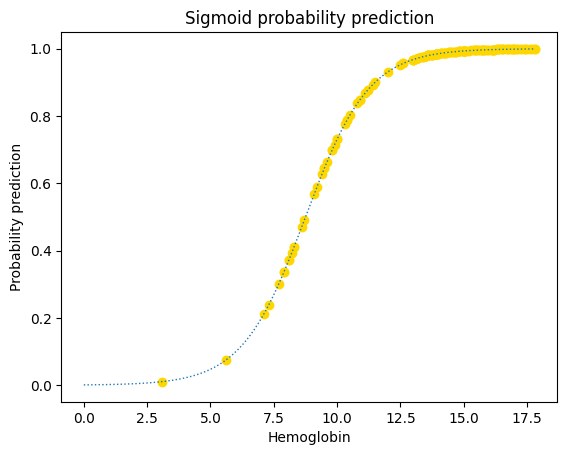

In [19]:
# show a plot of the probability prediction curve
plt.scatter(hemoglobin, predictions_new, color='gold')
plt.plot(fine_x, fine_y_sigmoid, linewidth=1, linestyle=':')
plt.title('Sigmoid probability prediction')
plt.xlabel('Hemoglobin')
plt.ylabel('Probability prediction');

Next we apply the conversion which converts probability to odds:

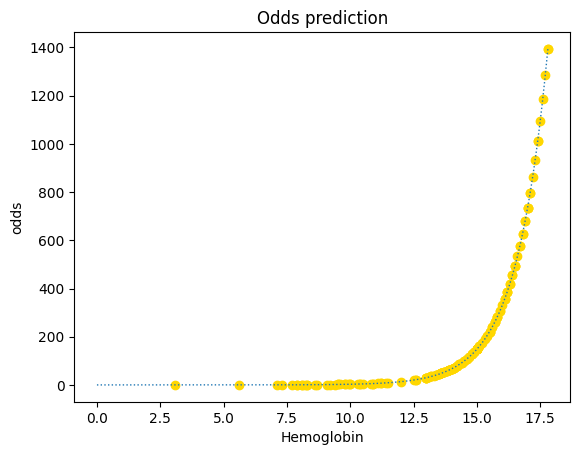

In [20]:
# show the predictions, on the odds scale
predictions_or = predictions_new / (1 - predictions_new)
plt.scatter(hemoglobin, predictions_or, color='gold')
fine_y_or = fine_y_sigmoid / (1 - fine_y_sigmoid)
plt.plot(fine_x, fine_y_or, linewidth=1, linestyle=':')
plt.title('Odds prediction')
plt.xlabel('Hemoglobin')
plt.ylabel('odds');

Notice that this is an *exponential* graph, where the y values increase more
and more steeply as the x values increase.  We can turn exponential lines like
this one into straight lines, using the *logarithm* function, the next stage of
the logit transformation:

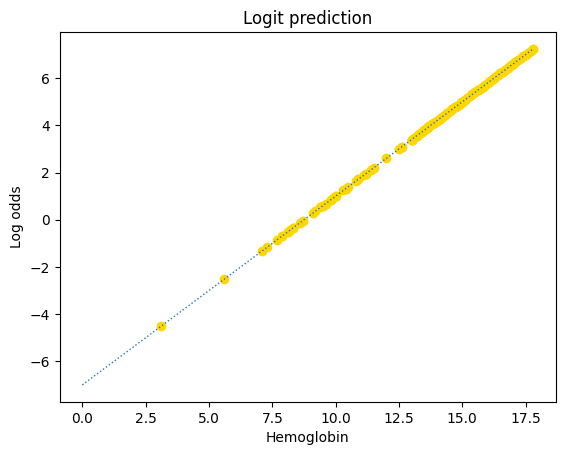

In [21]:
# show the predictions on the log odds scale
predictions_or_log = np.log(predictions_or)
plt.scatter(hemoglobin, predictions_or_log, color='gold')
fine_y_or_log = np.log(fine_y_or)
plt.plot(fine_x, fine_y_or_log, linewidth=1, linestyle=':')
plt.title('Logit prediction')
plt.xlabel('Hemoglobin')
plt.ylabel('Log odds');

We can do this conversion *in either direction*:

* straight line -> sigmoid curve
* sigmoid curve -> straight line

**This has the important consequence that** we can get `minimize` to find us a straight line,
then we can use our conversion to go back to the sigmoid curve. The sigmoid curve is on the original scale
of the data, where the outcome variable ranges between 0 and 1. We can then calculate error values
from the sigmoid curve and the original data points.

Pause here and re-read the last paragraph again. It is very important to understand
*why* we are doing these transformations, in order to not get lost in the detail.
To reiterate these are the steps:

- we (or `minimize`) generate a straight line (via a slope/intercept pairing)
- we transform this straight line into a sigmoid curve
- we assess use a goodness-of-fit metric (like error scores) to assess the fit of the sigmoid curve
- we repeat this process until we (or `minimize`) find the best-fitting sigmoid curve

The next few sections go into more detail on the odds and logarithm transformation steps.

## Probability and Odds

Because logistic regression uses probability and odds, we will go over these
foundational concepts in this section.

Specifically, for logistic regression, in contrast to linear regression, we are interested in
predicting the *probability of an observation falling into a particular outcome
category* (0 or 1). 

In our case `0 == poor appetite` and `1 == good appetite`.
So, we are interested in the probability of a patient having `good`
appetite, predicted from the patient's `hemoglobin` score.

We can think of probability as the *proportion of times* we expect to see a
particular outcome. 

For example, there are 139 patients with `good` appetite in this data frame,
and 158 patients in total.  If you were to repeatedly draw a single patient at
random from the data frame, and record their `appetite`, then we expect the proportion of "good" values in the long run, to be $\Large \frac{139}{158}$ --- which is about $0.88$.  That is the same as saying there is a probability of 0.88 of a randomly-drawn patient of having a `good` appetite.

In [22]:
# the probability of having a `good` appetite
hgb_app['appetite_dummy'].value_counts()/len(hgb_app)

appetite_dummy
1    0.879747
0    0.120253
Name: count, dtype: float64

Because the patient's appetite can only be `good` or `poor`, and because the
probabilities of all possible options have to add up to 1, the probability of
the patient having a `poor` appetite is $1 - 0.88$, which is about $0.12$.

So, the probability can express the *proportion of times* we expect to see some
*event of interest* - in our case, the event of interest is "good" in the
`appetite` column:

$\Large \text{probability} = \frac{\text{number of things of interest}}{\text{total number of things}}$

We can think of this same information as an *odds*.

We often express probabilities as odds. To break this down, for clarity let's think of a scenario with
some nice, clean probabilities.

Imagine there are 100 people standing in a room. 20 of them are civil servants. In this scenario, our *event of interest* is "being a civil servant". 
If we picked a person at random, the probability they will be a civil servant is:

$\text{Prob(Civil Servant}) = \Large \frac{20}{100}$.

By contrast, the odds is the number of times we expect to see the event of interest
(e.g. being a civil servant) for every time we expect to see the event of no interest (NOT
being a civil servant):

$ \Large \text{odds} = \frac{\text{number of things of interest}}{\text{number of things NOT of interest}}$

In the civil servant example, the *odds* of being a civil servant, if we pick a person at random, are:

$\text{Odds(Civil Servant}) = \Large \frac{20}{80}$.

This is just a way of saying a probability in a different way, and we can convert easily between probabilities and odds.

To convert from a probability to an odds, we remember that the odds is the number of times we expect to see the event of interest for every time we expect to see the event of no interest.   This is the probability (proportion) for the event of interest, divided by the probability (proportion) of the event of NO interest.  

We get the probability of events of no interest by subtracting the probability of an event of interest from 1.

Let's look at the probability $p$:

In [23]:
# Our probability of interest 
p = 20/100
p

0.2

In mathematical notation:

$ \Large \text{probability} = \frac{\text{number of things of interest}}{\text{total number of things}} = \frac{20}{100} = 0.2$

The equivalent odds here is:

$\Large \text{odds} = \frac{\text{number of things of interest}}{\text{number of things NOT of interest}} = \frac{20}{80} = 0.25$

We can also calculate the odds using this formula:

$\Large \text{odds} = \frac{\text{Prob(Event of Interest)}}{1 - \text{Prob(Event of Interest)}}$ 

In [24]:
# odds is proportion of interest, divided by proportion of no interest.
odds = p / (1 - p)
odds

0.25

$(1 - p)$ gives the the probability of events which are not of interest (in this case, this is people who are NOT civil servants):

$\text{Prob(Civil Servant}) = \Large \frac{20}{100}$

$\text{Prob(NOT Civil Servant}) = \Large \frac{80}{100}$

Let's demonstrate this in python:

In [25]:
(1 - p) == 80/100

True

When you are interpretting odds:  

**Odds of 1 indicate that the event of interest is equally as likely as events NOT of interest.**

**Odds of less than one means that the event of interest is less likely to happen than
events NOT of interest.**.  

**Odds of greater than one means the event of interest is more likely to
happen than events NOT of interest.**

**If the probability of an event of interest is 0, then the odds are 0.**

You can use the slider in the output of the cell below to set the probability of a hypothetical event of interest.
(If you want a probability of 50%, set the slider to 50, if you want a probability of 30%, set the slider to 30 and so on).
The printout will then allow you to relate the probability to the odds of the event of interest:

In [26]:
def odds_interact(probability_percent=50):

    assert (probability_percent >= 0) & (probability_percent <=99.99), "You must enter a percentage between 0 and 99.99!"

    p = probability_percent/100

    jupyprint(f"If a probability of an event of interest is **{probability_percent}%**:")
    jupyprint("$\\text{Prob(Event of Interest)} = \\frac{"+f"{probability_percent}"+"}{100}$")
    jupyprint(f"Then the odds of the event of interest are **{round(p/(1-p), 4)}**")
    jupyprint("$\\text{Odds(Event of Interest)} = \\frac{"+f"{probability_percent}"+"}{"+f"{100-probability_percent}"+"}$")

interact(odds_interact, probability_percent=(0, 99, 1))

If a probability of an event of interest is **50%**:

$\text{Prob(Event of Interest)} = \frac{50}{100}$

Then the odds of the event of interest are **1.0**

$\text{Odds(Event of Interest)} = \frac{50}{50}$

interactive(children=(IntSlider(value=50, description='probability_percent', max=99), Output()), _dom_classes=…

<function __main__.odds_interact(probability_percent=50)>

As the probability of an event of interest gets very close to 1, the odds gets very large - this means the event of interest is many many times more likely than events of no interest:

In [27]:
p_approaching_1 = 0.9999999999999999
large_odds = p_approaching_1 / (1 - p_approaching_1)
large_odds

9007199254740991.0

Remember the example above where the probability of being a civil servant was
$\frac{20}{100}$? We can also convert from odds to probabilities.  Remember the odds is
the number of times we expect to see the event of interest, divided by the
number of times we expect to see the event of no interest.  The probability is
the proportion of events of interest out of all events.  

We can convert back to the probability from the odds, using this formula:

$ \Large p = \frac{\text{odds}}{1 + \text{odds}} = \frac{0.25}{1.25} = 0.2 $

In [28]:
# convert from odds to probability
p_from_odds = odds / (1 + odds)
p_from_odds

0.2

In summary here is that we can convert probabilities to odds with:

In [29]:
# convert from probability to odds
odds = p / (1 - p)
odds

0.25

And we can convert odds to probabilities with:

In [30]:
# convert odds to probabilities
p = odds / (odds + 1)
p

0.2

As you've seen, for the current data, and for sigmoid probability curve we showed you above, when we apply the conversion to convert the probability
values to odds, we get the following (this is the graphical perspective on the probability-to-odds transformation just shown above):

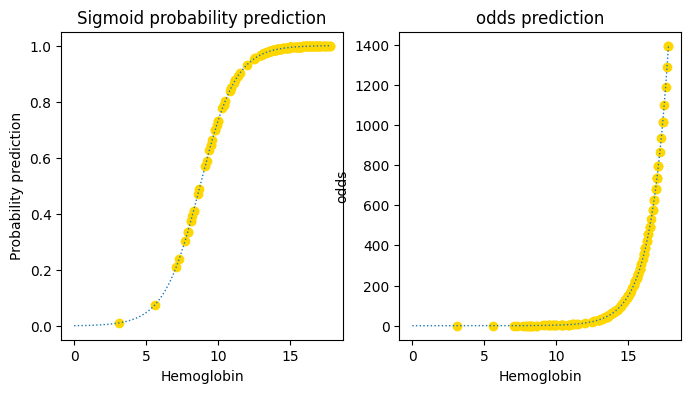

In [31]:
# show a plot of the probability prediction curve
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(hemoglobin, predictions_new, color='gold')
plt.plot(fine_x, fine_y_sigmoid, linewidth=1, linestyle=':')
plt.title('Sigmoid probability prediction')
plt.xlabel('Hemoglobin')
plt.ylabel('Probability prediction')
# converting from probabilities to odds
plt.subplot(1, 2,2)
predictions_or = predictions_new / (1 - predictions_new)
plt.scatter(hemoglobin, predictions_or,
            color='gold')
fine_y_or = fine_y_sigmoid / (1 - fine_y_sigmoid)
plt.plot(fine_x, fine_y_or, linewidth=1, linestyle=':')
plt.title('odds prediction')
plt.xlabel('Hemoglobin')
plt.ylabel('odds');

Notice that the odds we found vary from very close to 0 (for probability
predictions very close to 0) to very large (for probability
predictions very close to 1).

Notice too that our graph looks exponential, and we want it to be a straight
line (so we can pass a slope/intercept pair to `minimize`).  

Our next step is to apply a *logarithm* transformation.

## The logarithm transform

See the [logarithm refresher](logarithms_refreshed) page for more background on
logarithms.

For now, **the only thing you need to know about logarithms is that they are
transformations that convert an exponential curve into a straight line**. 

However, a very brief description is given just below. *We strongly recommend reading
the rest of the page first (skip to the next graph we show), and then come back
and read this brief explanation of logarithms*.

Essentially, a logarithm is an answer to the question "given a number, what power
would I have to raise a specific other number to, in order to get the first number?".

So, let's call that first number $a$, let's raise it to the the power $n$ and call the result
$y$:

$\Large a^n = y$

Here's an example:

In [32]:
a = 10
n = 2
y = a**n
y

100

A logarithm tells us, given our value of $a$, what power would we have to raise $a$ to, to get $y$?

We can write this as:

$\Large \log_{a}(y) = n$

You can read this as "if you give me the number $y$, what power would I have to raise the number $a$ to, in order to get $y$?".

As you can imagine, `numpy` functions exist to calculate logs:

In [33]:
np.log10(y)

2.0

In [34]:
np.log10(y) == n

True

The most important thing to understand is that logarithms transform an exponential graph into a straight line:

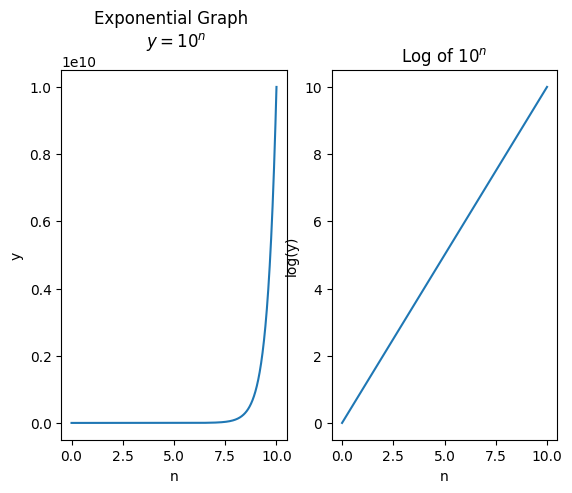

In [35]:
n = np.linspace(0, 10, 1000)
y = a ** n
fig, axes = plt.subplots(1, 2)
ax0, ax1 = axes
ax0.plot(n, y)
ax0.set_xlabel('n')
ax0.set_ylabel('y')
ax0.set_title('Exponential Graph \n $y=10^n$')
ax1.set_xlabel('n')
ax1.set_ylabel('log(y)')
ax1.plot(n, np.log10(y))
ax1.set_title(r'Log of $10^n$');

You have already see logs in action transforming the odds predictions.

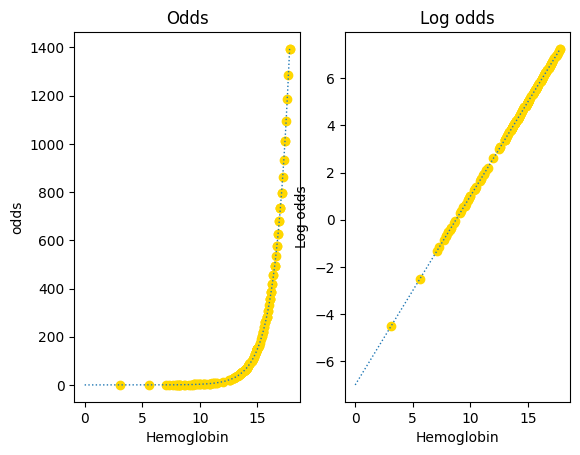

In [36]:
fig, axes = plt.subplots(1, 2)
ax0, ax1 = axes
ax0.scatter(hemoglobin, predictions_or, color='gold')
ax0.plot(fine_x, fine_y_or, linewidth=1, linestyle=':')
ax0.set_title('Odds')
ax0.set_xlabel('Hemoglobin')
ax0.set_ylabel('odds');
ax1.scatter(hemoglobin, predictions_or_log, color='gold')
ax1.plot(fine_x, fine_y_or_log, linewidth=1, linestyle=':')
ax1.set_title('Log odds')
ax1.set_xlabel('Hemoglobin')
ax1.set_ylabel('Log odds');

## The logit transform and its inverse

The logit transformation from the sigmoid curve to the straight line consists
of two steps:

* Convert probability to odds.
* Take the log of the result.

The full logit transformation is therefore:

In [37]:
def logit(p):
    """ Apply logit transformation to array of probabilities `p`
    """
    odds = p / (1 - p)
    return np.log(odds)

Here are the original sigmoid predictions and the predictions with the `logit` transform applied:

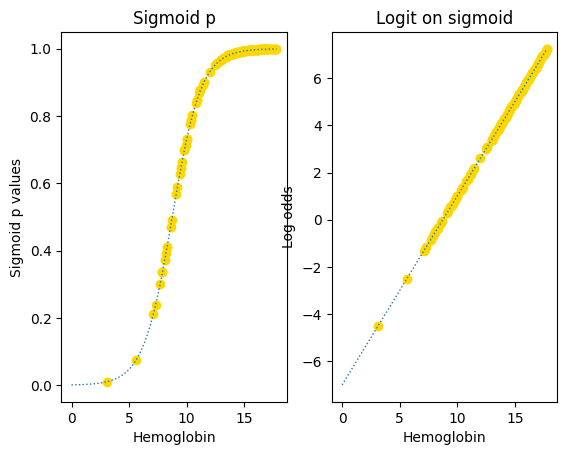

In [38]:
fig, axes = plt.subplots(1, 2)
ax0, ax1 = axes
ax0.scatter(hemoglobin, predictions_new, color='gold')
ax0.plot(fine_x, fine_y_sigmoid, linewidth=1, linestyle=':')
ax0.set_title('Sigmoid p')
ax0.set_xlabel('Hemoglobin')
ax0.set_ylabel('Sigmoid p values');
ax1.scatter(hemoglobin, logit(predictions_new), color='gold')
ax1.plot(fine_x, logit(fine_y_sigmoid), linewidth=1, linestyle=':')
ax1.set_title('Logit on sigmoid')
ax1.set_xlabel('Hemoglobin')
ax1.set_ylabel('Log odds');

We also want to be able to go backwards, from the straight-line predictions, to
the sigmoid predictions.

`np.exp` reverses (inverts) the `np.log` transformation (see the [logarithm
refresher](logarithms_refreshed) page):

In [39]:
# np.exp reverses the effect of np.log.
# let's take some values...
some_values = np.array([1, 0.5, 3, 6, 0.1])
some_values

array([1. , 0.5, 3. , 6. , 0.1])

In [40]:
# let's find the logarithm of these values...
logged_values = np.log(some_values)
logged_values

array([ 0.        , -0.69314718,  1.09861229,  1.79175947, -2.30258509])

In [41]:
# np.exp reverses the effect of np.log
values_back = np.exp(np.log(some_values))
values_back

array([1. , 0.5, 3. , 6. , 0.1])

You have seen above that there is a simple formula to go from odds to
probabilities.  The transformation that *reverses*  (inverts) the logit
transform is therefore:

In [42]:
def inverse_logit(v):
    """ Reverse logit transformation on array `v`
    """
    odds = np.exp(v)  # Reverse the log operation.
    return odds / (odds + 1)  # Reverse odds operation.

`inverse_logit` takes points on a straight line, and converts them to points on a
sigmoid.

First we convince ourselves that `inverse_logit` does indeed reverse the `logit`
transform:

In [43]:
# some probability values
some_p_values = np.array([0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99])
some_p_values

array([0.01, 0.05, 0.1 , 0.5 , 0.9 , 0.95, 0.99])

In [44]:
# we apply the logit transformation
some_log_odds = logit(some_p_values)
some_log_odds

array([-4.59511985, -2.94443898, -2.19722458,  0.        ,  2.19722458,
        2.94443898,  4.59511985])

In [45]:
# we use the inverse logit transformation to go back to the original values
back_again = inverse_logit(some_log_odds)
print('Logit, then inverse_logit returns the original data:')
back_again

Logit, then inverse_logit returns the original data:


array([0.01, 0.05, 0.1 , 0.5 , 0.9 , 0.95, 0.99])

The plot above has the sigmoid curve p-value predictions, and the p-value
predictions with the logit transformation applied.

Next you see the logit-transformed results on the left.  The right shows the
results of applying `inverse_logit` to recover the original p values.

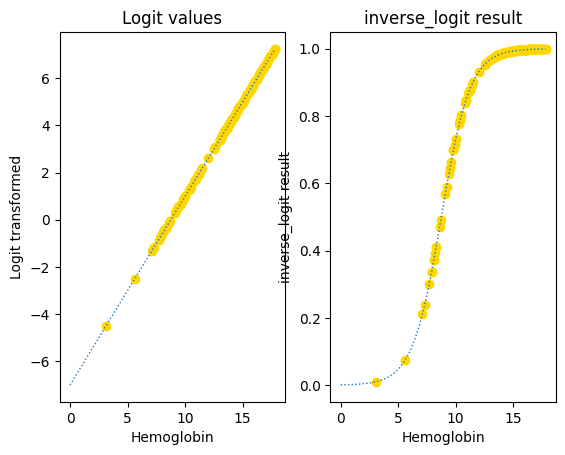

In [46]:
fig, axes = plt.subplots(1, 2)
ax0, ax1 = axes
ax0.scatter(hemoglobin, predictions_or_log, color='gold')
ax0.set_title('Logit values')
ax0.set_xlabel('Hemoglobin')
ax0.set_ylabel('Logit transformed');
ax0.plot(fine_x, fine_y_or_log, linewidth=1, linestyle=':')
ax1.scatter(hemoglobin, predictions_new,
            color='gold')
ax1.set_title('inverse_logit result')
ax1.set_xlabel('Hemoglobin')
ax1.set_ylabel('inverse_logit result');
ax1.plot(fine_x, inverse_logit(fine_y_or_log), linewidth=1, linestyle=':');

In summary here:

* the logit transformation converts probabilities to odds, then to log-odds
* the inverse logit transformation converts log odds to odds, then to probabilities

Let's pause to recapitulate why we are covering these transformations:

- we are interested in modelling the probability of some binary categorical outcome, as a function of another variable
- to do this, we'd like to pass a slope/intercept pair to `minimize`, but a straight line doesn't
  fit the binary categorical outcome variable very well

So, to our solution here is:
- we (or `minimize`) generate a straight line (via a slope/intercept pairing)
- we transform this straight line into a sigmoid curve (usinverse logit ing the transfrmations sh) above: 
- we assess use a goodness-of-fit metric (like error scores) to assess the fit of the sigmoid curve
- we repeat this process until we (or `minimize`) find the best-fitting siegmoid curv

## Effect of the Logit slope and intercept on the sigmoid

Let's explore what effect specific slope/intercept values have on the shape
of the sigmoid curve.

Changing the intercept of the logit (log-odds) straight line moves the
corresponding inverse logit sigmoid curve left and right on the horizontal
axis:

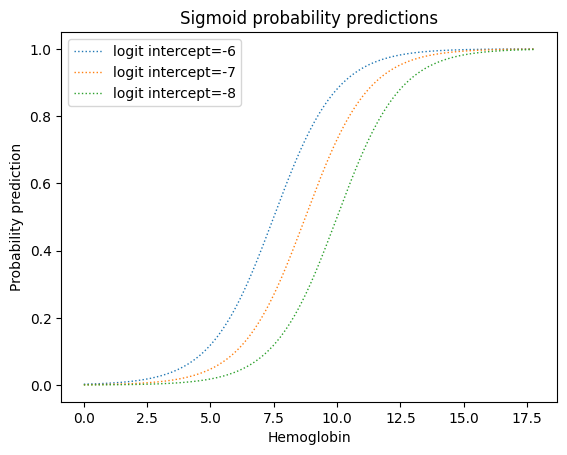

In [47]:
for intercept in [-6, -7, -8]:
    plt.plot(fine_x,
            params_to_predicted_probabilities(intercept, 0.8, fine_x),
            linewidth=1,
            linestyle=':',
            label='logit intercept=%d' % intercept)
plt.title('Sigmoid probability predictions')
plt.xlabel('Hemoglobin')
plt.ylabel('Probability prediction')
plt.legend();

Changing the slope of the logit straight line makes the transition from 0 to 1
flatter or steeper:

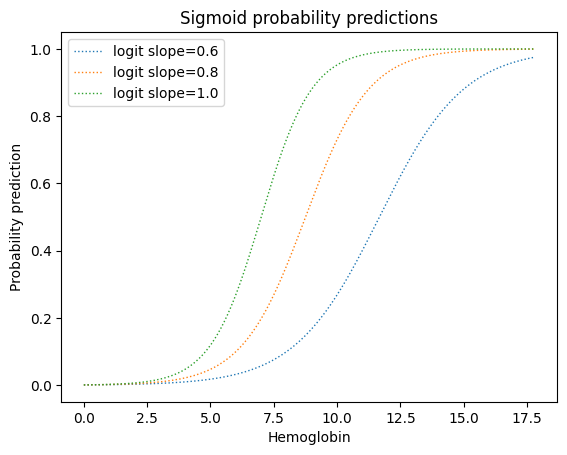

In [48]:
for slope in [0.6, 0.8, 1.0]:
    plt.plot(fine_x,
            params_to_predicted_probabilities(-7, slope, fine_x),
            linewidth=1,
            linestyle=':',
            label='logit slope=%.1f' % slope)
plt.title('Sigmoid probability predictions')
plt.xlabel('Hemoglobin')
plt.ylabel('Probability prediction')
plt.legend();

## A first-pass at logistic regression

Hopefully now you can see how we can use `minimize`, with a slope and intercept pair,
to fit a sigmoid curve to a binary categorical outcome variable.

Remember that `minimize` needs a *cost function* that takes some parameters -
in our case, the intercept and slope — and returns a score, or cost for the
parameters.

In the `ss_any_line` cost function above, the score it returns is just the sum
of squared prediction errors from the line.  But the cost function can do
anything it likes to generate a score from the line or curve.

In our case, we're going to make a cost function that:
- takes the intercept and slope, and generates predictions using the intercept and slope and `hemoglobin`
values.
- the cost function then converts these predictions into probability
predictions, on a corresponding sigmoid curve, and compares these predictions to the 0 or 1 values
in `appetite_d`.

For example, let's say we want to get a score for the intercept -7 and the
slope 0.8.

First we get the straight-line predictions in the usual way:

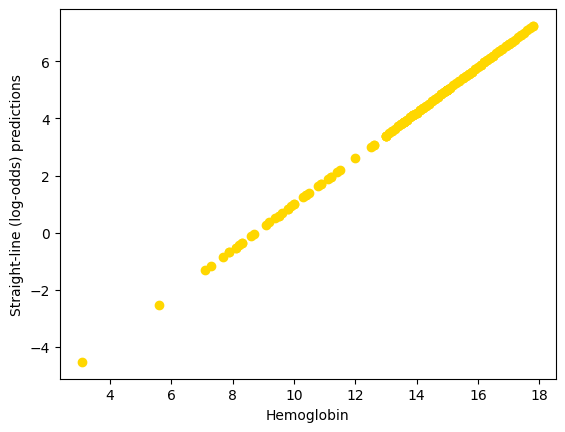

In [49]:
intercept, slope = -7, 0.8
sl_predictions = intercept + slope * hemoglobin
plt.scatter(hemoglobin, sl_predictions, color = 'gold')
plt.xlabel('Hemoglobin')
plt.ylabel('Straight-line (log-odds) predictions');

These are predictions on the straight line, but we now need to transform them
to p value (0 to 1) predictions on the sigmoid.  We use `inverse_logit`:

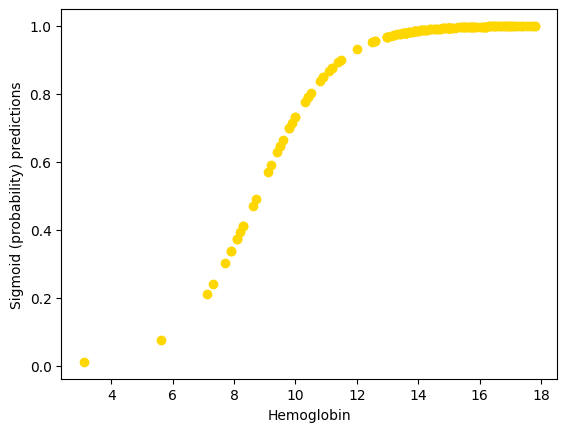

In [50]:
sigmoid_predictions = inverse_logit(sl_predictions)

plt.scatter(hemoglobin, sigmoid_predictions, color = 'gold')
plt.xlabel('Hemoglobin')
plt.ylabel('Sigmoid (probability) predictions');

Finally, we want to compare the predictions to the actual data to get a score.
One way we could do this is our good old sum of the squared errors between the
sigmoid p-value predictions and the 0 or 1 values:

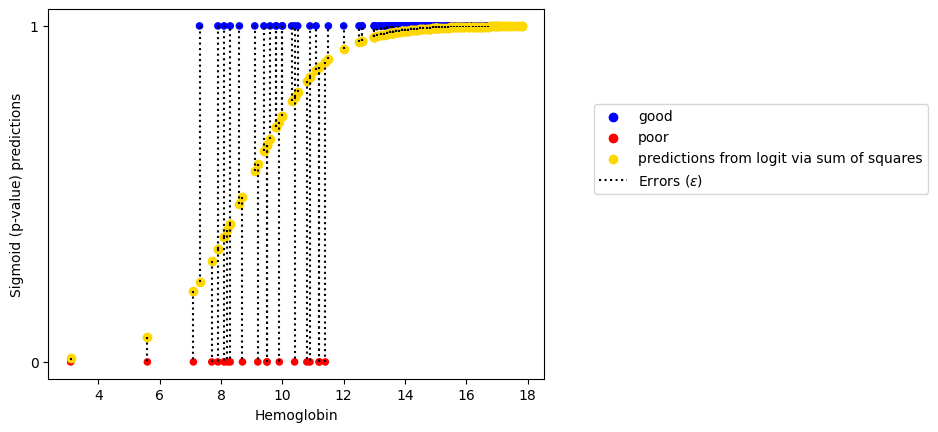

In [51]:
plot_hgb_app()
plt.scatter(hemoglobin, sigmoid_predictions, color = 'gold', label = 'predictions from logit via sum of squares')
for i in np.arange(len(hemoglobin)):
    plt.plot([hemoglobin[i], hemoglobin[i]], [sigmoid_predictions[i], appetite_d[i]], 'k:')
# the following code line is just to trick Matplotlib into making a new
# a single legend entry for the dotted lines.
plt.plot([], [], 'k:', label='Errors ($ \\varepsilon $)')
plt.xlabel('Hemoglobin')
plt.ylabel('Sigmoid (p-value) predictions')
plt.legend(loc=(1.1, 0.5));

In [52]:
sigmoid_error = appetite_d - sigmoid_predictions
sigmoid_sum_squared_error = np.sum(sigmoid_error ** 2)
sigmoid_sum_squared_error

10.044653157567184

Next we make the cost function that minimize will use.  It must accept an array
of parameters (an intercept and slope), and calculate the root mean squared error,
using the predicted probabilities:

In [53]:
def ss_logit(intercept_and_slope, x_values, y_values):
    
    # Unpack intercept and slope into values.
    intercept, slope = intercept_and_slope
    
    # Predicted values for log-odds straight line.
    predicted_log_odds = intercept + slope * x_values
    
    # Convert the straight line predictions to a sigmoid probability curve.
    predicted_probabilities = inverse_logit(predicted_log_odds)
    
    # Calculate the prediction errors.
    sigmoid_error = y_values - predicted_probabilities
    
    # Root mean squared error
    return np.sum(sigmoid_error ** 2)

We check our function gives the same results as the step-by-step calculation above.

In [54]:
ss_logit([-7, 0.8], hemoglobin, appetite_d)

10.044653157567184

Notice what is happening here.  The cost function gets the new intercept and
slope to try, makes the predictions from the intercept and slope, converts the
predictions to probabilities on the sigmoid, and tests those against the real
`appetite_d` values.

Now let's see the cost function in action:

In [55]:
# use `minimize` to find the slope/intercept which give the minimum value of our cost function
min_res_logit = minimize(ss_logit, [-7, 0.8], args=(hemoglobin, appetite_d))
min_res_logit

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 9.621504133676307
        x: [-5.281e+00  5.849e-01]
      nit: 12
      jac: [ 1.192e-07  1.192e-07]
 hess_inv: [[ 6.186e+00 -5.856e-01]
            [-5.856e-01  5.801e-02]]
     nfev: 42
     njev: 14

Does this result look like it gives more convincing sigmoid predictions than
our guessed intercept an slope of -7 and 0.8?

First get the sigmoid predictions from this line:

In [56]:
logit_ss_inter, logit_ss_slope = min_res_logit.x

jupyprint(f"Intercept of best-fitting line on the log odds scale: **{logit_ss_inter.round(2)}**")
jupyprint(f"Slope of best-fitting line on the log odds scale: **{logit_ss_slope.round(2)}**")

Intercept of best-fitting line on the log odds scale: **-5.28**

Slope of best-fitting line on the log odds scale: **0.58**

In [57]:
# Predicted values on log-odds straight line.
predicted_log_odds = logit_ss_inter + logit_ss_slope * hemoglobin

predicted_log_odds

0      1.270421
1      0.276024
2      1.036445
3     -2.005241
4     -0.776868
         ...   
153    3.902650
154    4.370602
155    3.961144
156    3.025241
157    3.961144
Name: hemoglobin, Length: 158, dtype: float64

Then convert these log-odds (straight line) predictions to probabilities, using the inverse logit transformation:

In [58]:
# Predicted p values on sigmoid.
logit_ss_predicted_prob_of_1 = inverse_logit(predicted_log_odds)

logit_ss_predicted_prob_of_1

0      0.780815
1      0.568571
2      0.738164
3      0.118654
4      0.314995
         ...   
153    0.980211
154    0.987514
155    0.981314
156    0.953701
157    0.981314
Name: hemoglobin, Length: 158, dtype: float64

Then plot the predictions, from the best-fitting slope and intercept pair:

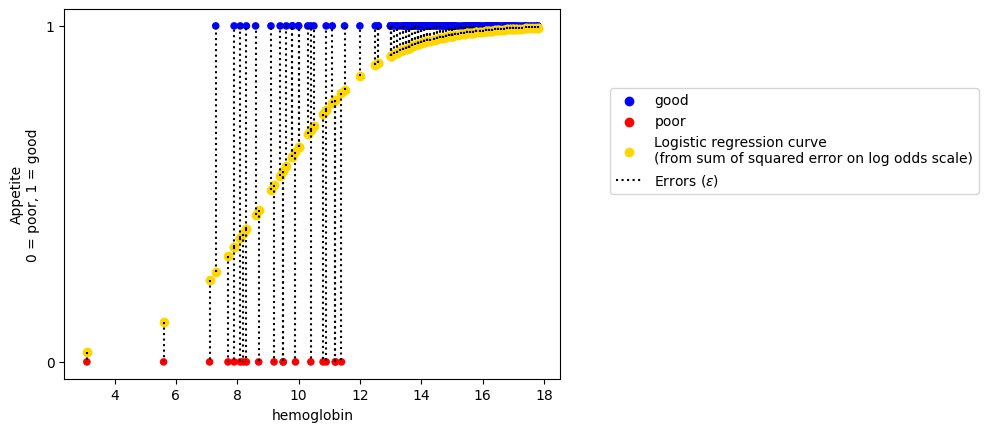

In [59]:
plot_hgb_app()
# A new plot on top of the old.
plt.scatter(hemoglobin, logit_ss_predicted_prob_of_1,
            label='Logistic regression curve \n(from sum of squared error on log odds scale)',
            color='gold')
for i in np.arange(len(hemoglobin)):
    plt.plot([hemoglobin[i], hemoglobin[i]], [logit_ss_predicted_prob_of_1[i], appetite_d[i]], 'k:')
    # the following code line is just to trick Matplotlib into making a new
    # a single legend entry for the dotted lines.
plt.plot([], [], 'k:', label='Errors ($ \\varepsilon $)')
    
# Show the legend.
plt.legend(loc=(1.1, 0.5));

## A different measure of prediction error

Our sigmoid prediction from sum of squares above looks convincing enough, but,
is there a better way of scoring the predictions from our line, than sum of
squares? E.g. could we use a different cost function which would work better?

It turns out there is another quite different and very useful way to score the
predictions, called *likelihood*.  For reasons we discuss in [this
page](logistic_convexity), all standard implementations of logistic regression
that we know of, use the *likelihood* measure that we describe below, instead
of the sum of squares measure you see above.

Likelihood asks the question: assuming our predicting line, how likely  is the
sequence of actual 0 and 1 values that we see?

To answer this question, we first ask this question about the individual 0 and 1
values.

We start with our intercept of -7 and slope of 0.8 for the straight-line
log-odds values.  We generate the straight-line predictions, then convert them
to sigmoid probability predictions.

In [60]:
# generate our straight line predictions
log_odds_predictions = -7 + hemoglobin * 0.8

# convert these to sigmoid probability predictions
sigmoid_p_predictions = inverse_logit(log_odds_predictions)

pd.DataFrame({'Log Odds Prediction': log_odds_predictions,
             'Probability Prediction': sigmoid_p_predictions})

,Log Odds Prediction,Probability Prediction
0,1.96,0.876533
1,0.60,0.645656
2,1.64,0.837535
3,-2.52,0.074468
4,-0.84,0.301535
...,...,...
153,5.56,0.996166
154,6.20,0.997975
155,5.64,0.996460
156,4.36,0.987383


Remember, the probability predictions are the predicted probabilities of `appetite_d == 1`. 
Let's name the predictions appropraitely to remind ourselves:

In [61]:
predicted_prob_of_1 = sigmoid_p_predictions

We put these predictions into a copy of our data set to make them easier to display:

In [62]:
hgb_predicted = hgb_app
hgb_predicted['predicted_prob_of_1'] = predicted_prob_of_1
hgb_predicted.head(20)

,hemoglobin,appetite,appetite_dummy,predicted_prob_of_1
0,11.2,poor,0,0.876533
1,9.5,poor,0,0.645656
2,10.8,poor,0,0.837535
3,5.6,poor,0,0.074468
4,7.7,poor,0,0.301535
5,9.8,good,1,0.698465
6,12.5,good,1,0.952574
7,10.0,good,1,0.731059
8,10.5,good,1,0.802184
9,9.8,good,1,0.698465


Let's look at a rown in the dataframe corresponding to an observational unit whose 
actual `appetite_d` score was 1. We'll use row number 5:

In [63]:
observation_1 = hgb_predicted.loc[5]
observation_1

hemoglobin                  9.8
appetite                   good
appetite_dummy                1
predicted_prob_of_1    0.698465
Name: 5, dtype: object

The `predicted_prob_of_1` value is the probability that we will see a `appetite_d` score of 1 for this
observation.   

The `appetite_d` score for this observation was, in fact, 1.  

Therefore the predicted probability that we will see the *actual `appetite_d` score is just the corresponding
`predicted_prob_of_1` value*:

In [64]:
predicted_prob_of_actual_score_obs_1 = observation_1['predicted_prob_of_1']
predicted_prob_of_actual_score_obs_1

0.698465216002539

Now consider an observational unit whose 
actual `appetite_d` score was 0. We'll use the observation in the first row of the dataframe:

In [65]:
observation_2 = hgb_predicted.loc[0]
observation_2

hemoglobin                 11.2
appetite                   poor
appetite_dummy                0
predicted_prob_of_1    0.876533
Name: 0, dtype: object

The probability for an `appetite_dummy` value of 1, for this observation is:

In [66]:
observation_2['predicted_prob_of_1']

0.876532952434776

However, **and this is absolutely crucial**: the actual `appetite_d` score of this observational unit 
was 0.

*Therefore the predicted probability of the **actual** score for this observational unit is **NOT** the predicted probability of a score of 1.*

The actual score was 0, so we need to calculate the predicted probability of a score of 0.

You'll remember that we can calculate the probability of the event NOT of interest by:

$\text{Prob(Event NOT of Interest)} = 1 - \text{Prob(Event of Interest)}$

Let's do this for the current observational unit:

In [67]:
predicted_prob_of_actual_score_obs_2 = 1 - observation_2['predicted_prob_of_1']
predicted_prob_of_actual_score_obs_2

0.12346704756522398

We can therefore calculate the predicted probability of each observational unit's **actual** score as follows.

We'll do with a for loop to make it conceptually clearer what is happening:

In [68]:
# an empty array to store our predicted probability of getting the actual `appetite_d` score, for
# each observational unit
predicted_prob_of_actual_score = np.empty(len(hgb_predicted))

# loop over all the observations
for i in np.arange(len(hgb_predicted)):

    # if the current observational unit (patient) had an `appetite_d` score of 1...
    if hgb_predicted['appetite_dummy'].iloc[i] == 1:
        
        # ...then record the predicted probability of 1 as the predicted probability of its actual score
        predicted_prob_of_actual_score[i] = hgb_predicted['predicted_prob_of_1'].iloc[i]

    # if the current observational unit (patient) had an `appetite_d` score of 0...
    if hgb_predicted['appetite_dummy'].iloc[i] == 0:
        
        # ...then record `1 minus the predicted probability of 1` as the predicted probability of its actual score
        predicted_prob_of_actual_score[i] = 1 - hgb_predicted['predicted_prob_of_1'].iloc[i]
        
# Put this into the data frame for display
hgb_predicted['predicted_prob_of_actual_score'] = predicted_prob_of_actual_score
hgb_predicted

,hemoglobin,appetite,appetite_dummy,predicted_prob_of_1,predicted_prob_of_actual_score
0,11.2,poor,0,0.876533,0.123467
1,9.5,poor,0,0.645656,0.354344
2,10.8,poor,0,0.837535,0.162465
3,5.6,poor,0,0.074468,0.925532
4,7.7,poor,0,0.301535,0.698465
...,...,...,...,...,...
153,15.7,good,1,0.996166,0.996166
154,16.5,good,1,0.997975,0.997975
155,15.8,good,1,0.996460,0.996460
156,14.2,good,1,0.987383,0.987383


Go through each row of the dataframe above. Notice that for observational units (patients) who
have an `appetite_d` score of 1, the `predicted_prob_of_actual_score` just equals their
`predicted_prob_of_1`. 

For observational units (patients) who have an `appetite_d` score of 0, the `predicted_prob_of_actual_score`
DOES NOT equal their  `predicted_prob_of_1`, it equals `1 - predicted_prob_of_1`.

**This is critical for understanding logistic regression:** for any slope/intercept pair we might use,
through the process just shown, we have a vector of probability predictions of the actual `appetite_d` score, for each observational unit.
We want all of these probabilities to be high e.g. we want the slope/intercept pair to give 
good predictions of the actual scores. We can use this to compare how well different
slope/intercept pairs fit the data.

**Pause for Questions**: let's take a pause to make sure the process just shown is clear.

There's a fancy short-cut to calculating the probabilities of the actual `appetite_d` scores.

We can create the `predicted_prob_of_actual_score` column by first
multiplying the 0 or 1 `appetite_d` scores by the values in `predicted_prob_of_1`.  This
correctly sets the `predicted_prob_of_actual_score` values for labels of 1, and leaves the
remainder as 0. 

Then we reverse the 0 and 1 labels by subtracting from 1, and
multiply by `1 - predicted_prob_of_1` to set the 0 values to their correct values.  Adding
these two results gives us the correct set of values for both 1 and 0 labels.

Let's break this down:

In [69]:
# get the predicted probability of the actual `appetite_d` scores, for
# observations where `appetite_d == 1`
probs_for_obs_with_good_appetite = appetite_d * predicted_prob_of_1
probs_for_obs_with_good_appetite

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
153    0.996166
154    0.997975
155    0.996460
156    0.987383
157    0.996460
Length: 158, dtype: float64

In [70]:
# get the predicted probability of the actual `appetite_d` scores, for
# observations where `appetite_d == 0`
probs_for_obs_with_bad_appetite = (1 - appetite_d) * (1 - predicted_prob_of_1)
probs_for_obs_with_bad_appetite

0      0.123467
1      0.354344
2      0.162465
3      0.925532
4      0.698465
         ...   
153    0.000000
154    0.000000
155    0.000000
156    0.000000
157    0.000000
Length: 158, dtype: float64

In [71]:
# Combine by adding.
final = probs_for_obs_with_good_appetite + probs_for_obs_with_bad_appetite 

final

0      0.123467
1      0.354344
2      0.162465
3      0.925532
4      0.698465
         ...   
153    0.996166
154    0.997975
155    0.996460
156    0.987383
157    0.996460
Length: 158, dtype: float64

In [72]:
# This gives the same result as the code cell above:
hgb_predicted['predicted_prob_of_actual_score_fancy'] = final
hgb_predicted

,hemoglobin,appetite,appetite_dummy,predicted_prob_of_1,predicted_prob_of_actual_score,predicted_prob_of_actual_score_fancy
0,11.2,poor,0,0.876533,0.123467,0.123467
1,9.5,poor,0,0.645656,0.354344,0.354344
2,10.8,poor,0,0.837535,0.162465,0.162465
3,5.6,poor,0,0.074468,0.925532,0.925532
4,7.7,poor,0,0.301535,0.698465,0.698465
...,...,...,...,...,...,...
153,15.7,good,1,0.996166,0.996166,0.996166
154,16.5,good,1,0.997975,0.997975,0.997975
155,15.8,good,1,0.996460,0.996460,0.996460
156,14.2,good,1,0.987383,0.987383,0.987383


We can do the whole cell above in one line:

In [73]:
# Compact version of pp of label calculation.
final_again = appetite_d * predicted_prob_of_1 + (1 - appetite_d) * (1 - predicted_prob_of_1)
hgb_predicted['predicted_prob_of_actual_score_again'] = final_again
hgb_predicted

,hemoglobin,appetite,appetite_dummy,predicted_prob_of_1,predicted_prob_of_actual_score,predicted_prob_of_actual_score_fancy,predicted_prob_of_actual_score_again
0,11.2,poor,0,0.876533,0.123467,0.123467,0.123467
1,9.5,poor,0,0.645656,0.354344,0.354344,0.354344
2,10.8,poor,0,0.837535,0.162465,0.162465,0.162465
3,5.6,poor,0,0.074468,0.925532,0.925532,0.925532
4,7.7,poor,0,0.301535,0.698465,0.698465,0.698465
...,...,...,...,...,...,...,...
153,15.7,good,1,0.996166,0.996166,0.996166,0.996166
154,16.5,good,1,0.997975,0.997975,0.997975,0.997975
155,15.8,good,1,0.996460,0.996460,0.996460,0.996460
156,14.2,good,1,0.987383,0.987383,0.987383,0.987383


When the `predicted_prob_of_actual_score` values are near 1, this means the result was close to
the prediction.  When they are near 0, it means the result was unlike the
prediction.

Now we know the probabilities of each actual 0 and 1 label, we can get a
measure of how *likely* the *combination* of all these labels are, given these
predictions. We do this by *multiplying* all the probabilities in
`predicted_prob_of_actual_score`.  When the probabilities in `predicted_prob_of_actual_score`
are all fairly near 1, multiplying them will give a number that is not very small.  When some or many
of the probabilities are close to 0, the multiplication will generate a very
small number.

The result of this multiplication is called the *likelihood* of this set of
labels, given the predictions.

If the predictions are closer to the actual values, the likelihood will be
larger, and closer to 1.  When the predictions are not close, the likelihood
will be low, and closer to 0.

Here is the likelihood for our intercept of -7 and slope of 0.8.

In [74]:
# np.prod multiplies each number to give the product of all the numbers.
likelihood = np.prod(hgb_predicted['predicted_prob_of_actual_score'])
likelihood

1.463854029404182e-13

This is a very small number.  Likelihoods are often close to 0 with a
reasonable number of points, and somewhat inexact prediction, because there
tend to be a reasonable number of small p values in `predicted_prob_of_actual_score`.  The
question is - do other values for the intercept and slope give smaller or
larger values for the likelihood?

We can put this *likelihood* scoring into our cost function, instead of using
scoring with the sum of squares.

One wrinkle is that we want our cost function value to be *lower* when the
line is a good predictor, but the likelihood is *higher* when the line is a
good predictor. We solve this simply by sticking a minus on the likelihood
before we return from the cost function. This makes `minimize` find the
parameters giving the *minimum* of the *negative likelihood*, and therefore,
the *maximum likelihood* (ML).

In [75]:
def simple_ml_logit_cost(intercept_and_slope, x, y):
    """ Simple version of cost function for maximum likelihood
    """
    intercept, slope = intercept_and_slope
    
    # Make predictions on the log odds (straight line) scale
    predicted_log_odds = intercept + slope * x

    # Convert these predictions to probabilities.
    predicted_prob_of_1 = inverse_logit(predicted_log_odds)
    
    # Calculate predicted probabilities of the actual scores (THIS IS THE MOST IMPORTANT STEP TO UNDERSTAND!)
    predicted_prob_of_actual_scores = y * predicted_prob_of_1 + (1 - y) * (1 - predicted_prob_of_1)

    # Multiply the predicted probabiity of the actual score
    likelihood = np.prod(predicted_prob_of_actual_scores)
    
    # Ask minimize to find maximum by adding minus sign.
    return -likelihood

**This is another key to understanding the logistic regression cost function:** 
- we generate predicted probabilities of an outcome score of  (`appetite_d` == 1)1, based on a slope/intercept pair
- we then calculate the predicted probability of each observational un'its *actual* score
- we multiply the probabilities of the actual score together, giving us a *likeihood* value
- the likelihood value is a metric of goodness-of-fit, like the sum of squared error
- we find the slope/intercept pair that gives the best fitting sigmoid, measured via the likel
- in practive we `minimize` the negative of the likelihoodihood

We canour new that cost function, starting at our familiar intercept of -7 and
slope of 0.8.

Before we do, there is one extra wrinkle, that we will solve in another way
further down the notebook.  At the moment the likelihood values we are
returning are very small - in the order of $10^{-13}$.  We expect scores for
different plausible lines to differ from each other by an even smaller number.
By default, `minimize` will treat these very small differences as
insignificant.  We can tell `minimize` to pay attention to these tiny
differences by passing a very small value to the `tol` parameter (`tol` for
*tolerance*).

In [76]:
logistic_reg_ML = minimize(simple_ml_logit_cost,  # Cost function
                 [-7, 0.8],  # Guessed intercept and slope
                 args=(hemoglobin, appetite_d),  # x and y values
                 tol=1e-16)  # Attend to tiny changes in cost function values.
# Show the result.
logistic_reg_ML

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -2.117164088219709e-13
        x: [-7.003e+00  7.722e-01]
      nit: 6
      jac: [ 2.279e-14 -2.254e-15]
 hess_inv: [[ 4.655e+07  4.707e+08]
            [ 4.707e+08  4.760e+09]]
     nfev: 166
     njev: 52

Let's look at the predictions to see if they are reasonable.

In [77]:
# get the parameter estimates back from `minimize`
inter_logistic_reg_ML, slope_logistic_reg_ML = logistic_reg_ML.x

# generate probability predictions (predicting probability of `appetite_d == 1`)
predicted_logistic_reg_ML = inverse_logit(inter_logistic_reg_ML + slope_logistic_reg_ML * hemoglobin)

# show the predictions
predicted_logistic_reg_ML 

0      0.838301
1      0.582473
2      0.791958
3      0.064251
4      0.257886
         ...   
153    0.994062
154    0.996790
155    0.994501
156    0.981333
157    0.994501
Name: hemoglobin, Length: 158, dtype: float64

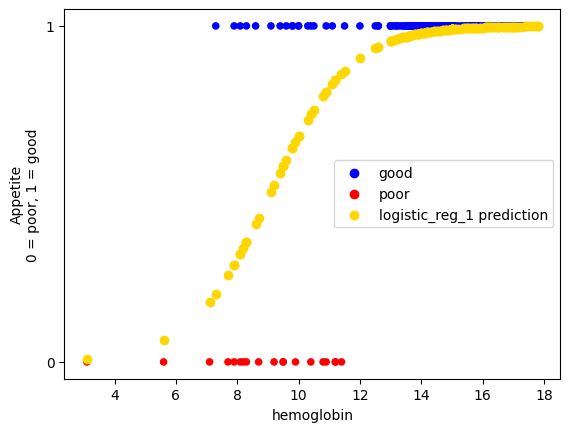

In [78]:
plot_hgb_app()
plt.scatter(hemoglobin, predicted_logistic_reg_ML, c='gold', label='logistic_reg_1 prediction')
plt.legend();

## A computation trick for the likelihood

As you have seen, the likelihood values can be, and often are, very small, and
close to zero.

You may also know that standard numerical calculations on computers are not
completely precise; the calculations are only accurate to around 16 decimal
places.  This is because of the way computers store floating point numbers.
You can find more detail in [this page on floating point
numbers](http://matthew-brett.github.io/teaching/floating_point.html).

The combination of small likelihood values, and limited calculation precision,
can be a problem for the simple ML logistic cost function you see above.  As a
result, practical implementations of logistic regression use an extra trick to
improve the calculation accuracy of the likelihoods.

This trick also involves logarithms.

Here we show a very important property of the logarithm transform:

In [79]:
print('Multiplying two numbers', 11 * 15)
print('Take logs, add logs, unlog', np.exp(np.log(11) + np.log(15)))

Multiplying two numbers 165
Take logs, add logs, unlog 165.00000000000009


What you see here is that we get (almost) the same answer if we:

* Multiply two numbers OR
* If we take the logs of the two numbers, *add them*, then reverse the log
  operation, in this case with `np.exp`.

We get *almost* the same number because of the limitations of the precision of
the calculations.  For our cases, we do not need to worry about these tiny
differences.

The log-add-unlog trick means that we can replace multiplication by addition,
if we take the logs of the values.

Here we do the same trick on an array of numbers:

In [80]:
some_numbers = np.array([11, 15, 1, 0.3])
print('Product of the array', np.prod(some_numbers))
print('Log-add-unlog on the array', np.exp(np.sum(np.log(some_numbers))))

Product of the array 49.5
Log-add-unlog on the array 49.500000000000036


We can use this same trick to calculate our likelihood by adding logs instead
of multiplying the probabilities directly:

In [81]:
print('Likelihood with product of array', np.prod(hgb_predicted['predicted_prob_of_actual_score']))
# The log-add-unlog version.
logs_of_predicted_prob = np.log(hgb_predicted['predicted_prob_of_actual_score'])
log_likelihood = np.sum(logs_of_predicted_prob)
print('Likelihood with log-add-unlog', np.exp(log_likelihood))

Likelihood with product of array 1.463854029404182e-13
Likelihood with log-add-unlog 1.4638540294041883e-13


This doesn't seem to have solved all our problem, because we still end up with
the type of tiny number that confuses `minimize`.

The next stage of the solution is to realize that the `minimize` does not need
the *actual likelihood*, it needs some number that goes *up or down in exactly
the same way as likelihood*.  If the cost function can return some number that
goes up when likelihood goes up, and goes down when likelihood goes down,
`minimize` will still find the same parameters to minimize this cost function.

Specifically we want the value that comes back from the cost function to vary
[monotonically](https://en.wikipedia.org/wiki/Monotonic_function) with respect
to the likelihood.  See the {ref}`discussion on monotonicity <monotonicity>` in
the [Sum of squares, root mean square](../mean-slopes/sse_rmse) page.

In our case you may be able to see that the likelihood and *log likelihood* are
monotonic with respect to each other, so if we find the parameters minimizing
log likelihood, those parameters will also minimize likelihood.

The plot below shows the monotonicity of likelihood and log likelihood.  You
can see it is true that when the likelihood goes up, then the log of the
likelihood will also go up, and vice versa, so the log the likelihood *is*
monotonic with respect to the likelihood, and we can use it instead of the
likelihood, in our cost function.

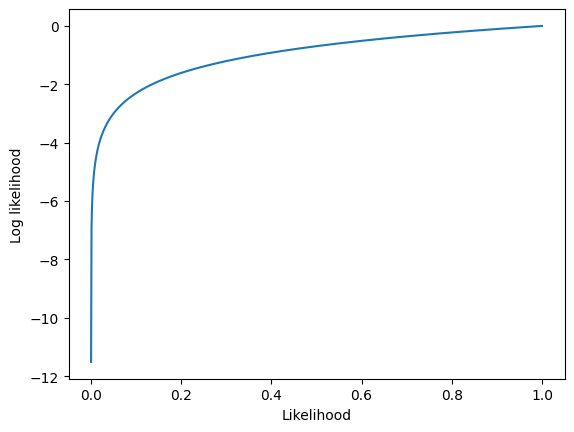

In [82]:
# show the relationship between the likelihood and log-likelihood
likelihood_values = np.linspace(1e-5, 1, 1000)
plt.plot(likelihood_values, np.log(likelihood_values))
plt.xlabel('Likelihood')
plt.ylabel('Log likelihood');

This means that our cost function does not have to do the last nasty unlog step
above, that generates the tiny value for likelihood.  We can just return the
(minus of the) log of the likelihood.  The log of the likelihood turns out to
be a manageable negative number, even when the resulting likelihood is tiny.

In [83]:
# the likelihood value from our guessed slope and intercept
likelihood

1.463854029404182e-13

In [84]:
# the log likelihood value, for the tiny likelihood above
log_likelihood

-29.552533505045645

This trick gives us a much more tractable number to return from the cost
function, because the log likelihood is much less affected by errors from lack
of precision in the calculation.

Let's modify our cost function, so it is now safer/easier for `minimize` to work with:

In [85]:
def mll_logit_cost(intercept_and_slope, x, y):
    """ Cost function for maximum log likelihood

    Return minus of the log of the likelihood.
    """
    intercept, slope = intercept_and_slope
    
    # Make predictions for on the log odds (straight line) scale.
    predicted_log_odds = intercept + slope * x

    # convert these predictions to sigmoid probability predictions
    predicted_prob_of_1 = inverse_logit(predicted_log_odds)

    # Calculate predicted probabilities of the actual score, for each observation.
    predicted_probability_of_actual_score = y * predicted_prob_of_1 + (1 - y) * (1 - predicted_prob_of_1)
    
    # Use logs to calculate log of the likelihood
    log_likelihood = np.sum(np.log(predicted_probability_of_actual_score))
    
    # Ask minimize to find maximum by adding minus sign.
    return -log_likelihood

Use the new cost function:

In [86]:
logistic_reg_MLL = minimize(mll_logit_cost,  # Cost function
                  [-7, 0.8],  # Guessed intercept and slope
                  args=(hemoglobin, appetite_d),  # x and y values
                  )
# Show the result.
logistic_reg_MLL

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 29.167993895856497
        x: [-7.292e+00  7.992e-01]
      nit: 7
      jac: [-2.384e-07  2.384e-07]
 hess_inv: [[ 2.751e+00 -2.574e-01]
            [-2.574e-01  2.513e-02]]
     nfev: 27
     njev: 9

Notice that we did not have to tell `minimize` to use a very small value for
the tolerance this time.

The values that come back are very similar to our previous, more fragile
version that used the likelihood:

In [87]:
inter_logistic_reg_MLL, slope_logistic_reg_MLL = logistic_reg_MLL.x
predicted_MLL = inverse_logit(inter_logistic_reg_MLL + slope_logistic_reg_MLL * hemoglobin)

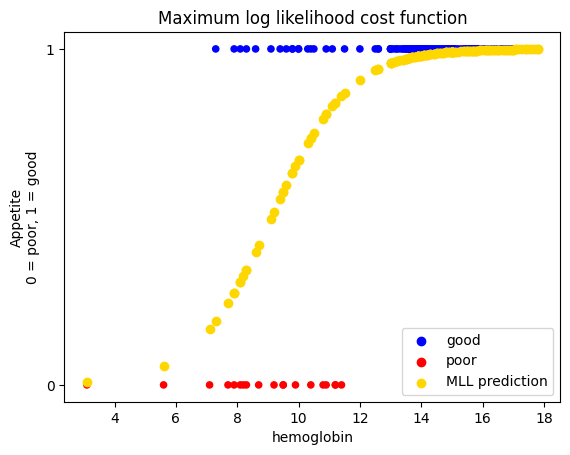

In [88]:
plot_hgb_app()
plt.scatter(hemoglobin, predicted_MLL, c='gold', label='MLL prediction')
plt.title('Maximum log likelihood cost function')
plt.legend();

You have just seen the standard calculations behind most packages that
implement logistic regression.

To show this is standard, let us do the same regression in Statsmodels

## Logistic Regression with Statsmodes

As with linear regression, we can easily perform logistic regression using
Statsmodels.

In [89]:
# Get the formula interface for Statsmodels
import statsmodels.formula.api as smf

In [90]:
# Create the model.
log_reg_mod = smf.logit('appetite_dummy ~ hemoglobin', data=hgb_app)
# Fit it.
fitted_log_reg_mod = log_reg_mod.fit()
fitted_log_reg_mod.summary()

Optimization terminated successfully.
         Current function value: 0.184608
         Iterations 8


/Users/mb312/Library/Python/3.10/lib/python/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/mb312/Library/Python/3.10/lib/python/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/mb312/Library/Python/3.10/lib/python/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/mb312/Library/Python/3.10/lib/python/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         appetite_dummy   No. Observations:                  158
Model:                          Logit   Df Residuals:                      156
Method:                           MLE   Df Model:                            1
Date:                Tue, 28 Nov 2023   Pseudo R-squ.:                  0.4976
Time:                        23:07:49   Log-Likelihood:                -29.168
converged:                       True   LL-Null:                       -58.054
Covariance Type:            nonrobust   LLR p-value:                 2.944e-14
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.2919      1.659     -4.396      0.000     -10.543      -4.041
hemoglobin     0.7992      0.158      5.042      0.000       0.489       1.110
==============================================================================
"""

Notice that Statsmodels lists the "Model" as "Logit" and the "Method" as "MLE"
— Maximum Likelihood Estimation.

Look at the table above under 'coef'. Compare the logistic regression intercept
and slope that Statsmodels found to the ones we got from `minimize` and the
maximum log likelihood (MLL) cost function.

In [91]:
jupyprint(f'Intercept from minimize = **{round(inter_logistic_reg_MLL, 3)}**')
jupyprint(f'Slope from minimize = **{round(slope_logistic_reg_MLL, 3)}**')

Intercept from minimize = **-7.292**

Slope from minimize = **0.799**

Finally, we can use the `predict` method of Statsmodels to generate predicted
probabilities from the logistic regression model we have just fitted:

In [92]:
sm_predictions = fitted_log_reg_mod.predict(hgb_app['hemoglobin'])
sm_predictions.head()

/Users/mb312/Library/Python/3.10/lib/python/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/mb312/Library/Python/3.10/lib/python/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)


0    0.840058
1    0.574466
2    0.792325
3    0.056433
4    0.242617
dtype: float64

Let us plot the predicted probabilities of having "good" appetite, from
Statsmodels:

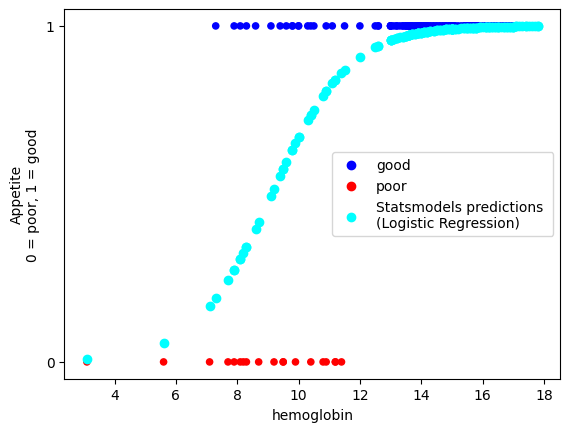

In [93]:
plot_hgb_app()
plt.scatter(hemoglobin, sm_predictions,
            label = 'Statsmodels predictions \n(Logistic Regression)', color = 'cyan')
plt.legend();

We can see graphically that these predictions look identical to the ones we
obtained from minimize.

Let us see what the largest absolute difference between the predictions from
the two methods is:

In [94]:
np.max(np.abs(predicted_MLL - sm_predictions))

4.520308660715955e-08

That is very close to 0. The models are making almost identical predictions.

## The meaning of the parameters

The slope and intercept returned by logistic regression show us something the (kind of) the exact same thing
in logistic regression as they tell us in linear regression:

- the intercept tells us the predicted outcome variable score for an observational unit where the predictor score == 0
- the slope tells us the expected change in the *log-odds* of an outcome variable score of 1, for a 1-unit chance in the predictor

It's not very intuitive to interpret the slope on the log-odds scale that it naturally comes to us on!
We can use `np.exp()` to convert the slope to the *odds scale*, so it has more intuitive meaning:

In [95]:
np.exp(slope_logistic_reg_MLL)

2.2236600999177156

We interpret this as "the odds of `appetite_d == 1` are multiplied byw2.2246for each 1-unit increase in the predictor.on

## Summary

This tutorial has shown you how to do binary logistic regression with one numerical predictor variable.
